# Imports

In [29]:
import numpy as np
import data_preprocessing as dp
import plotting as p
import modeling as m

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Constants

In [30]:
# Panama
PA_FIRST_LOCATION_RUN = False

pa_shape_path = "data/Panama/panama_rect.shx"

pa_s2_rasters = ["data/Panama/S2_panama_T17PPK_20211210.tif", "data/Panama/S2_panama_T17PPL_20221210.tif"]
pa_s2_merged_path = "data/Panama/S2_merged_20211210.tif"
pa_s2_path = 'data/Panama/S2_merged_20211210_reproj.tif'

pa_s1_no_process_path = "data/Panama/S1_inter_20220128_20220209.geo.unw.tif"
pa_s1_path = 'data/Panama/S1_inter_20220128_20220209_reproj.geo.unw.tif'

pa_capella_path = "data/Panama/CAPELLA_C09_SM_GEO_HH_20240806035526_20240806035544.tif"

pa_iceye_no_process_path = "data/Panama/ICEYE_GRD_SC_244270_20220207T192226.tif_Cal_Spk_TC.tif"
pa_iceye_path = 'data/Panama/ICEYE_GRD_SC_244270_20220207T192226.tif_Cal_Spk_TC_reproj.tif'

EXPERIMENT_RUN = 'interferogram' # 'optical', 'interferogram', 'all', 'iceye'
NUM_SIMULATIONS = 30

# Data preprocessing

#### Set up

In [31]:
pa_aoi = dp.get_aoi_geometry(pa_shape_path, PA_FIRST_LOCATION_RUN)
pa_aoi = pa_aoi.set_crs("EPSG:4326", allow_override=True)

if PA_FIRST_LOCATION_RUN:
    dp.get_sentinel2(pa_aoi, pa_s2_path, pa_s2_merged_path, ((0, 0), (0, 1), (0, 0)),
                      temp_file=pa_s2_merged_path, list_files=pa_s2_rasters
                      )
    dp.get_interferogram(pa_aoi, pa_s1_path, ((0, 0), (0, 1), (0, 1)), 
                        pa_s1_no_process_path
                    )
    dp.get_iceye(pa_aoi, pa_iceye_path, ((0, 0), (0, 1)), pa_iceye_no_process_path)
    dp.get_ref_data(pa_aoi, 'data/Panama/ref_data_abg_woody.tif', ((1, 0), (0, 0)),
                     'data/Panama/60N_010E.tif'
                    )

#### Optical - Sentinel 2

In [32]:
pa_s2_data,_ = dp.get_sentinel2(aoi=pa_aoi, file_path=pa_s2_path, 
                                             padding=((0, 0), (0, 0), (0, 1)), plot=False
                                            )

#### InSAR - Sentinel 1

In [33]:
pa_s1_data,_ = dp.get_interferogram(aoi=pa_aoi, file_path=pa_s1_path, 
                                                 padding=((0, 0), (0, 1), (0, 0)), plot=False
                                                )

#### SAR - Iceye

In [34]:
pa_iceye_data,_ = dp.get_iceye(aoi=pa_aoi, file_path=pa_iceye_path, 
                                               padding=((0, 0), (0, 1)), plot=False
                                              )

#### Stacking

In [35]:
if EXPERIMENT_RUN == 'optical':
    pa_combined = pa_s2_data
elif EXPERIMENT_RUN == 'interferogram':
    pa_combined = pa_s1_data
elif EXPERIMENT_RUN == 'iceye':
    pa_combined = pa_iceye_data
elif EXPERIMENT_RUN == 'all':
    pa_combined = np.concatenate((pa_s2_data, pa_s1_data, pa_iceye_data), axis=0)

#### Reference data

In [36]:
pa_ref_data,_ = dp.get_ref_data(aoi=pa_aoi, file_path='data/Panama/ref_data_abg_woody.tif', 
                                              padding=((0,0), (0,0)), plot=False)

In [37]:
del pa_s2_data, pa_s1_data, pa_iceye_data, pa_shape_path, pa_s2_rasters, \
    pa_s2_merged_path, pa_s2_path, pa_s1_no_process_path, pa_s1_path, \
    pa_capella_path, pa_iceye_no_process_path, pa_iceye_path, 

#### Formatting for models

In [38]:
pa_n_bands, pa_height, pa_width = pa_combined.shape
n_pixels = pa_height * pa_width

# Reshape to make the bands last
pa_X_2d = np.transpose(pa_combined, (1, 2, 0)).reshape(n_pixels, pa_n_bands)       # (w*h, 14)
pa_y_1d = pa_ref_data.reshape(n_pixels)             # (w*h, )


# For no image processers
# Impute missing values in X (mean strategy)
imputer = SimpleImputer(strategy='mean')
pa_X_2d = imputer.fit_transform(pa_X_2d)

# Split into test and train 
pa_X_train, pa_X_test, pa_y_train, pa_y_test = train_test_split(
    pa_X_2d, pa_y_1d, test_size=0.3, random_state=42
)

In [39]:
del pa_ref_data, pa_aoi, pa_combined, pa_n_bands, n_pixels, pa_y_1d

# Experiments

### MLR

In [40]:
# No need t run experiments in this bc mathematically deterministic
_, mlr_runtime, mlr_rmse, mlr_r2 = m.mlr(pa_X_train, pa_y_train, pa_X_test, pa_y_test, pa_X_2d, pa_height, pa_width, output=False)

if True: # PA_FIRST_LOCATION_RUN
    with open('data/output/pa.txt', 'a') as file:
        file.write('MLR control (%s):\n' % EXPERIMENT_RUN)
        file.write(str({'mlr': [mlr_runtime, mlr_rmse, mlr_r2]}))
        file.write('\n\n')

### RF

##### Parameter experiments

In [41]:
n_estimators = [50, 125, 200]
max_tree_depths = [10, 15, 30]

if EXPERIMENT_RUN == 'all': 
    rf_output = m.parameter_experiments(n_estimators, max_tree_depths, NUM_SIMULATIONS, 'rf', pa_X_train, pa_y_train, pa_X_test, 
                                pa_y_test, pa_X_2d, pa_height, pa_width)

    with open('data/output/pa.txt', 'a') as file:
        file.write('RF Parameter Experiments Output:\n')
        file.write(str(rf_output))
        file.write('\n\n')
    
    del rf_output

##### Input data experiments

In [42]:
if EXPERIMENT_RUN != 'all':
    input_experiment_output_rf = m.parameter_experiments([50], [30], NUM_SIMULATIONS, 'rf', pa_X_train, pa_y_train, pa_X_test, 
                                pa_y_test, pa_X_2d, pa_height, pa_width)
    
    with open('data/output/pa.txt', 'a') as file:
        file.write('RF Input Data Experiments Output (%s):\n' % EXPERIMENT_RUN)
        file.write(str(input_experiment_output_rf))
        file.write('\n\n')
    
    del input_experiment_output_rf

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   10.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.7min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.6s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:   11.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parall

### GBT

##### Parameter experiments

Training Time: 293.86 seconds
RMSE: 62.76729202270508 Mg/ha
R² Score: 0.71149742603302


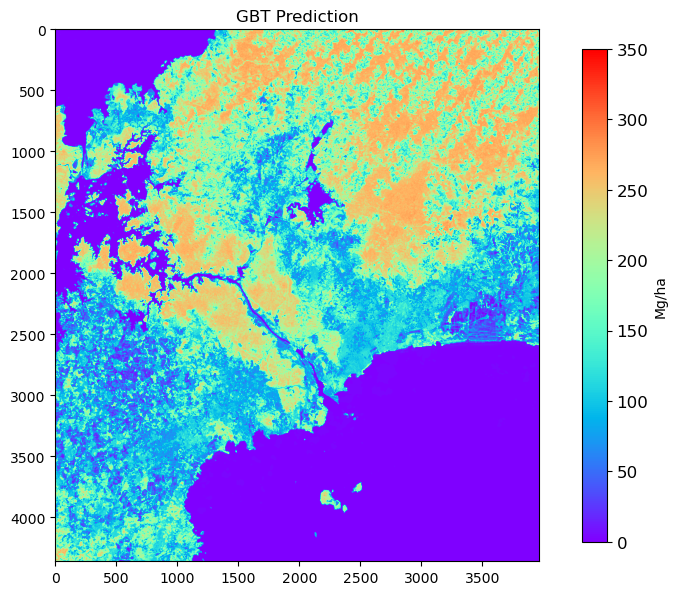

(array([1.2221539e-02, 1.2169056e+02, 1.6083397e+01, ..., 1.4287064e+02,
        1.1098828e+02, 1.6475009e+02], dtype=float32),
 293.85804414749146,
 62.767292,
 0.71149742603302)

In [ ]:
if EXPERIMENT_RUN == 'all':
    gbt_output = m.parameter_experiments(n_estimators, max_tree_depths, NUM_SIMULATIONS, 'gbt', pa_X_train, pa_y_train, pa_X_test, 
                                pa_y_test, pa_X_2d, pa_height, pa_width)

    with open('data/output/pa.txt', 'a') as file:
        file.write('GBT Parameter Experiments Output:\n')
        file.write(str(gbt_output))
        file.write('\n\n')
    
    del gbt_output

##### Input data experiments

In [ ]:
if EXPERIMENT_RUN != 'all':
    input_experiment_output_gbt = m.parameter_experiments([50], [15], NUM_SIMULATIONS, 'gbt', pa_X_train, pa_y_train, pa_X_test, 
                                pa_y_test, pa_X_2d, pa_height, pa_width)

    with open('data/output/pa.txt', 'a') as file:
        file.write('GBT Input Data Experiments Output (%s):\n' % EXPERIMENT_RUN)
        file.write(str(input_experiment_output_gbt))
        file.write('\n\n')